### Model context defined for the notebook
If the notebook deals only one model (maybe multiple versions), you can use %%ml model to define a default model. In other cells, you don't need to specify the model name again and it will pick the default model.

In [9]:
%%ml model --name census

### Define Training Dataset
Training needs preprocessed data that are created in previous preprocess-local notebook.

In [10]:
%%ml dataset --name census_data
train: /content/mldata/preprocessed_train
test: /content/mldata/preprocessed_test
metadata: /content/mldata/metadata.yaml

Alternatively, you can put data in Cloud Storage and local training should work as well. For example:

In [ ]:
%%ml dataset --name census_data_gcs
train: gs://your-bucket/census/preprocessed_train
test: gs://your-bucket/census/preprocessed_test
metadata: gs://your-bucket/census/metadata.yaml

### Define your tensorflow graph

In [11]:
%%tensorflow graph


import google.cloud.ml as cloudml
import google.cloud.ml.models as models
import json
import math
import tensorflow as tf
from tensorflow.python.ops import sparse_ops as sparse_ops


class CensusModel(models.Classification):
  def __init__(self):
    super(CensusModel, self).__init__()
    
  def create_graph(self):
    with tf.Graph().as_default() as g:
      attrs, text = self._create_inputs()
      hidden_layer = self._create_hidden_layer(attrs, text['ids'], text['values'])
      logits = self._create_logits_layer(hidden_layer)
      self._create_outputs(logits)
      self._create_training(logits)
      self._create_initialization()
    return g
  
  def _create_inputs(self):
    with tf.name_scope('inputs'):
      self.examples = tf.placeholder(tf.string, name = 'examples')
      parsed_examples = self.parse_features(self.examples)
      self.targets = parsed_examples['target']
      # Our input data doesn't have Ids.
      # Assign empty strings to the ids tensor, in the same shape as the targets.
      self.keys = tf.fill(tf.shape(self.targets), tf.constant('', dtype=tf.string), name='keys')
      return parsed_examples['attrs'], parsed_examples['native_country']
    
  def _create_hidden_layer(self, attrs, ids, values):
    attrs_size = self.metadata.features['attrs']['size']
    text_size = self.metadata.features['native_country']['size']
    output_size = self.hyperparams.hidden_layer_size
    
    with tf.name_scope('hidden_layer'):
      initial_weights = tf.truncated_normal([ attrs_size, output_size ],
                                            stddev = 1.0 / math.sqrt(attrs_size))
      weights = tf.Variable(initial_weights, name = 'weights')
      initial_biases = tf.zeros([ output_size ])
      biases = tf.Variable(initial_biases, name = 'biases')
      xw = tf.matmul(attrs, weights)
      xwb = tf.nn.bias_add(xw, biases)

      initial_weights_text = tf.truncated_normal([text_size, output_size],
                                                 stddev=1.0 / math.sqrt(text_size))
      weights_text = tf.Variable(initial_weights_text, name='weights_text')
      initial_biases_text = tf.zeros([output_size])
      biases_text = tf.Variable(initial_biases_text, name='biases_text')
      sparse_text = sparse_ops.sparse_merge(ids, values, text_size, 'sparse_merge')
      xw_text = sparse_ops.sparse_tensor_dense_matmul(sparse_text, weights_text, name='text_embedding_lookup')
      xwb_text = tf.nn.bias_add(xw_text, biases_text)
      xwb_combined = xwb_text + xwb
      return tf.nn.relu(xwb_combined)
    
  def _create_logits_layer(self, hidden_layer):
    input_size = self.hyperparams.hidden_layer_size
    output_size = self.metadata.labels
    with tf.name_scope('logits_layer'):
      initial_weights = tf.truncated_normal([input_size, output_size],
                                            stddev=1.0 / math.sqrt(input_size))
      weights = tf.Variable(initial_weights, name='weights')
      initial_biases = tf.zeros([output_size])
      biases = tf.Variable(initial_biases, name='biases')
      return tf.nn.bias_add(tf.matmul(hidden_layer, weights), biases)
    
  def _create_outputs(self, logits):
    with tf.name_scope('outputs'):
      self.scores = tf.nn.softmax(logits, name='scores')
      # The tensor in self.predictions will be compared to self.targets
      # by the cloud service during evaluation.
      self.predictions = tf.arg_max(logits, 1, name='prediction')
      
  def _create_training(self, logits):
    with tf.name_scope('train'):
      with tf.name_scope('target'):
        tensor = tf.convert_to_tensor(self.targets)
        batch_size = tf.shape(tensor)[0]
        hot_rows = tf.cast(tf.expand_dims(
            tf.range(0, batch_size), 1), tensor.dtype)
        hot_indices = tf.concat(concat_dim = 1, values = [ hot_rows, tensor ])
        shape = tf.cast(tf.pack([batch_size, self.metadata.labels]), tensor.dtype)
        encoded_targets = tf.sparse_to_dense(
            hot_indices,
            shape,
            sparse_values = tf.constant(1, dtype = tf.float32),
            default_value = tf.constant(0, dtype = tf.float32))
      entropy = tf.nn.softmax_cross_entropy_with_logits(logits,
                                                        encoded_targets)
      self.loss = tf.reduce_mean(entropy, name = 'loss')
      self.global_step = tf.Variable(0, name='global_step', trainable=False)
      optimizer = tf.train.AdagradOptimizer(self.hyperparams.learning_rate)
      self.train = optimizer.minimize(self.loss, self.global_step)
      
  def _create_initialization(self):
    self.initialize = tf.initialize_all_variables()

### Training

Before you start training, you may want to visualize the graph. --visualize does this.

In [ ]:
%%ml train -v v1 -d census_data --overwrite --visualize
batch_size: 64
learning_rate: 0.01
hidden_layer_size: 100
steps: 1000

Start training (same command but without -v).

In [6]:
%%ml train -v v1 -d census_data --overwrite
batch_size: 64
learning_rate: 0.01
hidden_layer_size: 100
steps: 1000

While it is being trained, you can watch training progress (loss, error) by:

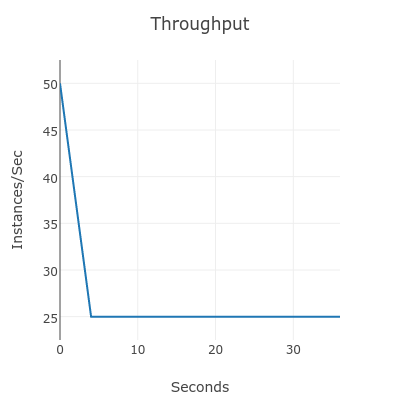

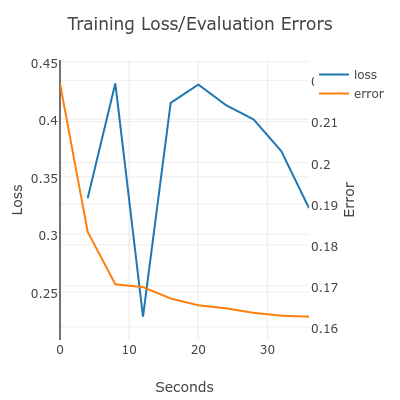

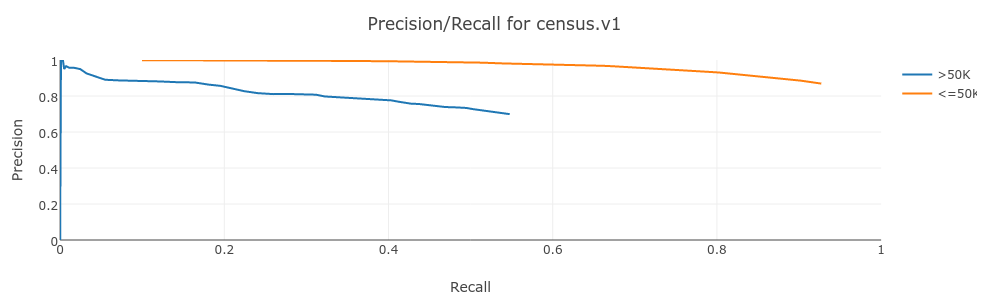

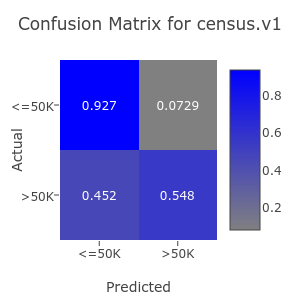

In [12]:
%%ml analyze -v v1

The same command will work after training is done. When the model is trained, you will also see confusion matrix and PR curve.

Let's train another model, with smaller hidden size.

In [13]:
%%ml train -v v2 -d census_data --overwrite
batch_size: 64
learning_rate: 0.01
hidden_layer_size: 20
steps: 1000

Now you can compare the performance of two models.

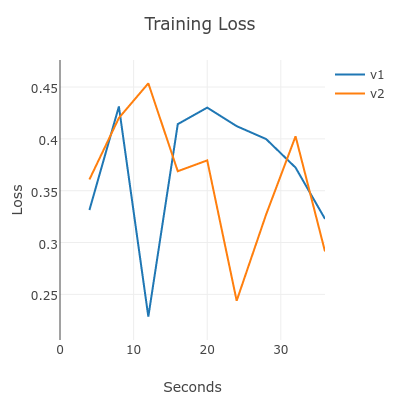

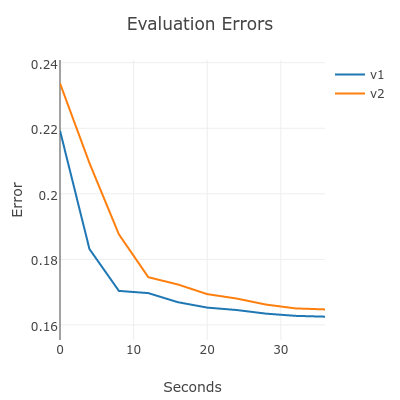

In [15]:
%%ml analyze -m census.v1 census.v2

Optionally, you can provide --output so the models are saved in your specified location.

In [7]:
%%bash
mkdir /notebooks/myml

In [8]:
%%ml train -v newlocation -d census_data --overwrite --output /notebooks/myml
batch_size: 64
learning_rate: 0.01
hidden_layer_size: 20
steps: 1000